In [1]:
from matplotlib import pylab 
params = {'xtick.labelsize': 18, 
'ytick.labelsize': 18, 
'axes.titlesize' : 22, 
'axes.labelsize' : 20, 
'legend.fontsize': 18, 
'legend.title_fontsize': 22, 
'figure.titlesize': 24 } 
pylab.rcParams.update(params)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pprint import pprint
from prepare import prepare_data
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, RegressorMixin


In [2]:
df = pd.read_csv("data_HW3.csv")
ASSAF_ID = 207376807
DANIEL_ID = 209088723
randomness = ASSAF_ID % 100 + DANIEL_ID % 100
# randomness = 148
train_set, test_set = train_test_split(
    df, random_state=randomness, test_size=0.2
)
prepared_train_set = prepare_data(df, train_set)
prepared_test_set = prepare_data(df, test_set)

# Preliminary: Updated Data Loading

# Section 1

## Task (pre-Q4)

In [3]:
class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """

    def __init__(self, lr: float = 1e-5, huber_delta: float = 1.0):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0
        self.delta = huber_delta
        self.huber_delta = huber_delta

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y, huber_delta: float):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # TODO: complete the loss calculation
        intermediate = np.dot(X, w) + b - y
        is_within_delta = np.abs(intermediate) <= huber_delta
        loss_inside = lambda x: 0.5 * (x**2)
        loss_outside = lambda x: huber_delta * (np.abs(x) - 0.5 * huber_delta)

        return np.sum(np.where(is_within_delta, loss_inside(intermediate), loss_outside(intermediate))) / X.shape[0]

    @staticmethod
    def gradient(w, b: float, X, y, huber_delta: float):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        intermediate = np.dot(X, w) + b - y
        is_within_delta = np.abs(intermediate) <= huber_delta
        g_w = np.mean(np.where(is_within_delta, X.T * intermediate, huber_delta * X.T * np.sign(intermediate)), axis=1)
        g_b = np.mean(np.where(is_within_delta, intermediate, huber_delta * np.sign(intermediate)))
        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True, X_val=None, y_val=None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b,  X, y, self.delta))
            val_losses.append(self.loss(self.w, self.b,  X_val, y_val, self.delta))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx:end_idx]
            batch_y = y[start_idx:end_idx]

            # TCompute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y, self.delta)

            # Perform a gradient step
            # update the learned parameters correctly
            self.w -= self.lr * g_w
            self.b -= self.lr * g_b
            # print(f"iteration {itr} b: {self.b}, w: {self.w} loss: {self.loss(self.w, self.b, X, y)}")

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b, X, y, self.delta))
                val_losses.append(self.loss(self.w, self.b, X_val, y_val, self.delta))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        y_pred = np.dot(X, self.w) + self.b

        return y_pred


In [4]:
def numerical_subgradient(w, b, X, y, huber_delta: float, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y, huber_delta)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y, huber_delta)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y, huber_delta) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, huber_delta: float, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y, huber_delta)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, huber_delta, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle("Residuals of analytical and numerical gradients", fontsize=22, fontweight="bold")
    axs[0].set_title(r"Residuals of $\nabla_{w}L\left(w,b\right)$")
    axs[1].set_title(r"Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$")
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale("log")
    axs[0].set_xscale("log")
    axs[1].set_yscale("log")
    axs[1].set_xscale("log")
    axs[0].set_xlabel(r"$\delta_w$", fontsize=18)
    axs[1].set_xlabel(r"$\delta_b$", fontsize=18)
    axs[0].set_ylabel(r"$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$", fontsize=18)
    axs[1].set_ylabel(r"$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$", fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()

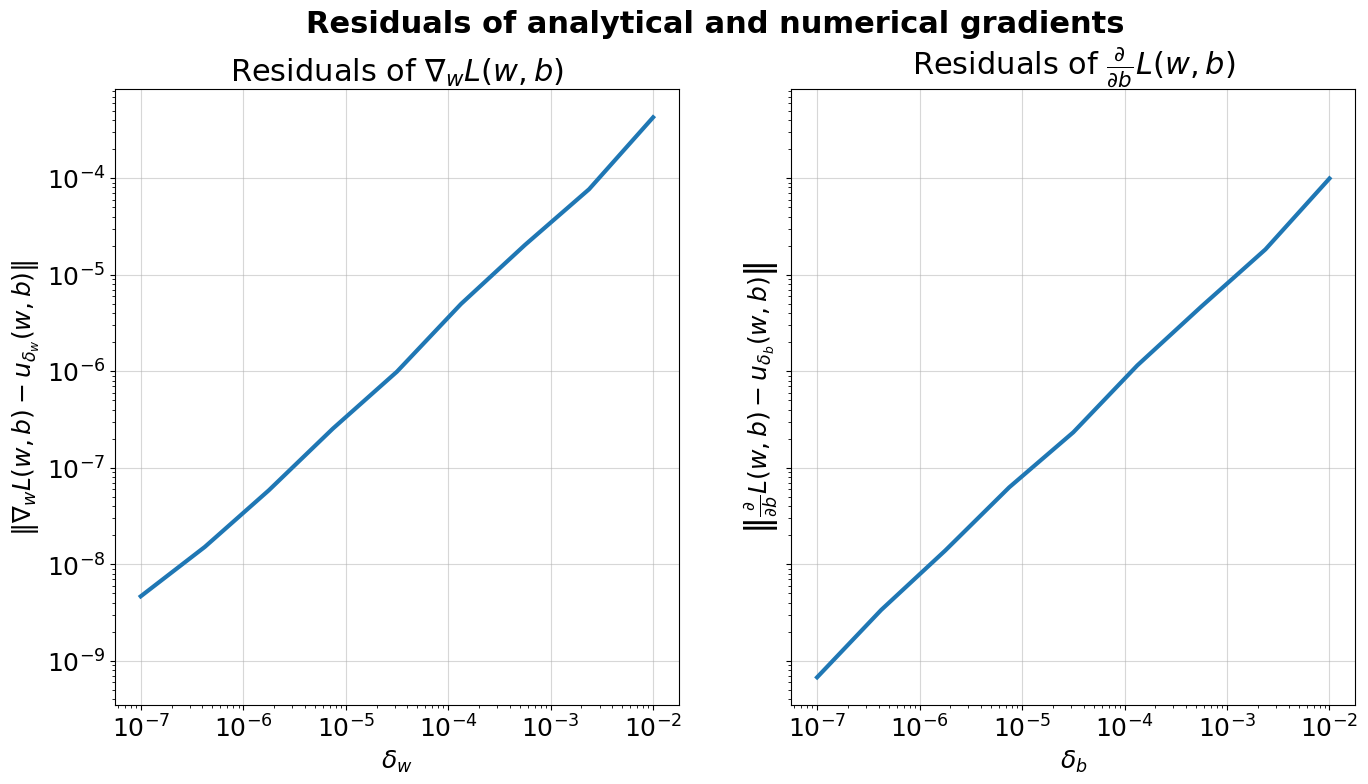

In [5]:
partial_train, partial_test = train_test_split(
    prepared_train_set, random_state=randomness, test_size=0.2
)
partial_test: pd.DataFrame
partial_train: pd.DataFrame
partial_train_X = partial_train.drop("contamination_level", axis=1).values
partial_train_y = partial_train["contamination_level"].values
compare_gradients(partial_train_X, partial_train_y, deltas=np.logspace(-7, -2, 9), huber_delta=0.1)

## Test LR

In [6]:
import matplotlib.pyplot as plt
import numpy as np


def test_lr(X_train, y_train, X_val, y_val, huber_delta: float, title: str, max_iter: int = 1500):
    lr_list = np.logspace(-9, -1, 9)

    fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
    plt.suptitle(title, fontsize=32)
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.5, top=0.9)

    axs = np.ravel(axs)
    for i, lr in enumerate(lr_list):
        cur_linear_reggressor = LinearRegressor(lr, huber_delta)
        train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter=max_iter)
        # print("lr size = " + str(lr) + ", Best train loss = " + str(min(train_losses)) + ", Best validation loss = " + str(min(val_losses)))

        iterations = np.arange(max_iter + 1)
        axs[i].semilogy(iterations, train_losses, label="Train")
        axs[i].semilogy(iterations, val_losses, label="Validation")
        axs[i].grid(alpha=0.5)
        axs[i].legend()
        axs[i].set_title("lr = " + str(lr))
        axs[i].set_xlabel("iteration")
        axs[i].set_ylabel("Huber Loss")

## Q5

In [7]:
from sklearn.model_selection import cross_validate

def get_best_delta(X, y, quantile_thresholds, cv=5):
    model = LinearRegressor(lr=0.01, huber_delta=100)
    model.fit(X, y)
    test_cv_scores = []
    train_cv_scores = []
    best_delta = 0
    residuals = y - model.predict(X)
    residuals = np.abs(residuals)
    deltas = list(np.quantile(residuals, quantile_thresholds))
    for delta in deltas:
        model = LinearRegressor(lr=0.01, huber_delta=delta)

        scores = cross_validate(model, X, y, cv=cv, return_train_score=True, n_jobs=8)
        test_cv_scores.append(np.mean(scores["test_score"]))
        train_cv_scores.append(np.mean(scores["train_score"]))

    best_delta = deltas[np.argmax(test_cv_scores)]
    print(f"train_cv_scores: {train_cv_scores}")
    print(f"test_cv_scores: {test_cv_scores}")
    print(f"Best delta: {best_delta}, corresponds to quantile: {quantile_thresholds[np.argmax(test_cv_scores)]}")

    return best_delta


quantile_thresholds = [0.5, 0.7, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]

best_delta = get_best_delta(partial_train_X, partial_train_y, quantile_thresholds, cv=5)
print(best_delta)

train_cv_scores: [0.16312321967029428, 0.22190676398951567, 0.2541878099657416, 0.29368804961610595, 0.30673056626255907, 0.30980397502073814, 0.3142083915851619, 0.31561238364848404, 0.3165006230312759, 0.31680942981204985]
test_cv_scores: [0.1411580418752963, 0.19161337948425622, 0.21730507305214591, 0.24555160459047576, 0.25284877241724635, 0.25350239006841724, 0.25331468176820005, 0.25265695805986654, 0.25192721330138385, 0.2516013847370491]
Best delta: 4.276225032567495, corresponds to quantile: 0.96
4.276225032567495


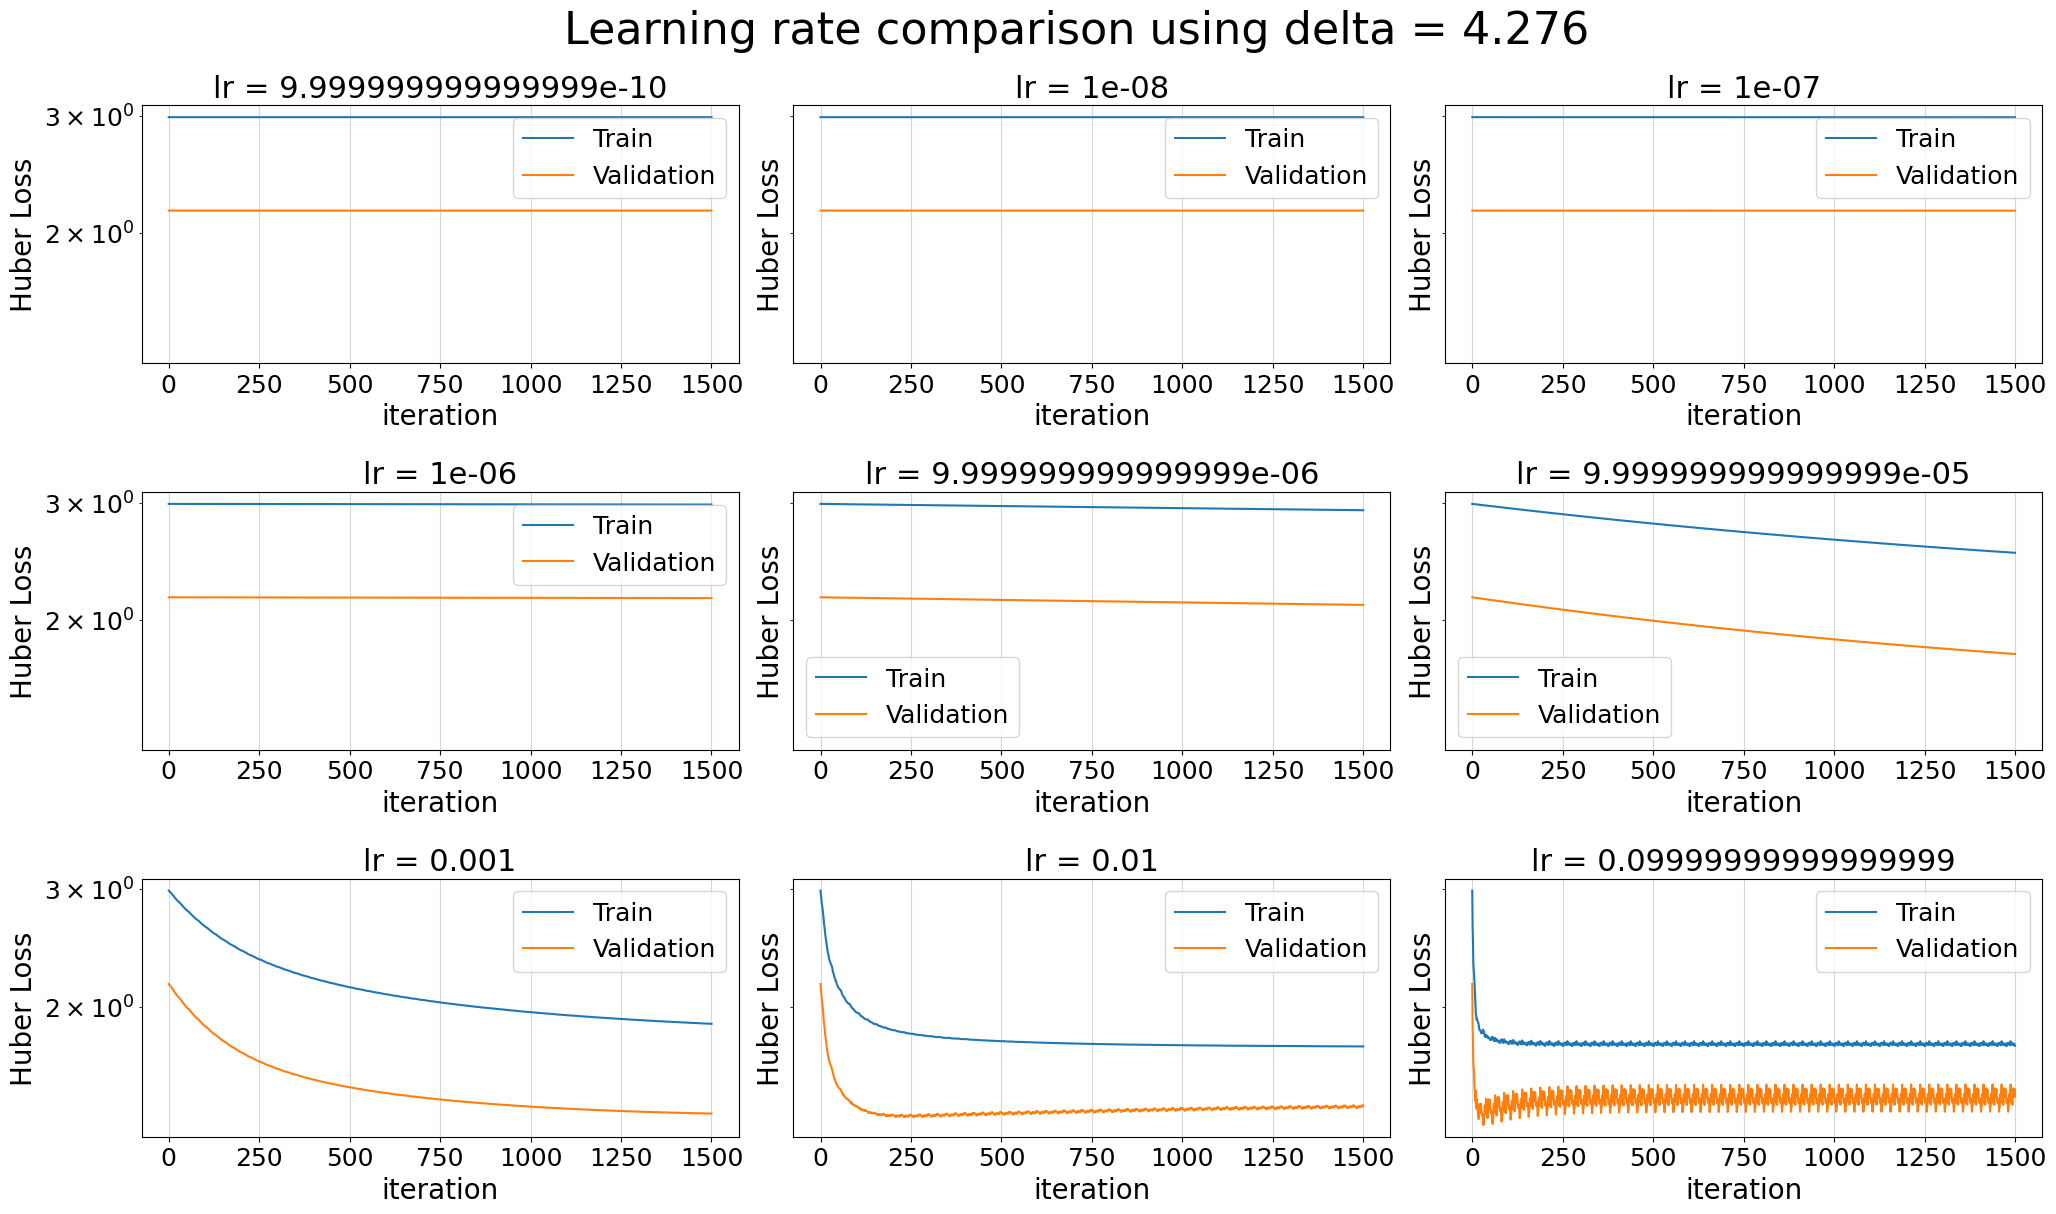

In [8]:
delta = best_delta  # from previous cell
partial_test: pd.DataFrame
# print(delta)
test_lr(
    partial_train_X,
    partial_train_y,
    partial_test.drop("contamination_level", axis=1).values,
    partial_test["contamination_level"].values,
    huber_delta=delta,
    title=f"Learning rate comparison using delta = {str(round(delta, 3))}",
)

# Section 2

## Q7

In [9]:
chosen_lr = 0.001
prepared_X = prepared_train_set.drop("contamination_level", axis=1)
prepared_y = prepared_train_set["contamination_level"]
from sklearn.dummy import DummyRegressor


dummy = DummyRegressor(strategy="mean")
scores = cross_validate(dummy, prepared_X, prepared_y, cv=5, return_train_score=True, n_jobs=5, scoring="neg_mean_squared_error")
dummy_validation_score = np.abs(np.mean(scores["test_score"]))
dummy_train_score = np.abs(np.mean(scores["train_score"]))

print(f"Training   score for Dummy: {dummy_train_score}")
print(f"Validation score for Dummy: {dummy_validation_score}")

# vvvvv Sanity check vvvvv
print(f"Actual mean value:          {prepared_y.mean()}")
mean_squared_error = np.mean((prepared_y - prepared_y.mean()) ** 2)
print(f"Mean squared error:         {mean_squared_error}")
# ^^^^^ Sanity check ^^^^^

dummy.fit(prepared_X, prepared_y)  # <-- Saved for future use

Training   score for Dummy: 5.03039255996928
Validation score for Dummy: 5.035714920817636
Actual mean value:          1.257646147718577
Mean squared error:         5.030924796054114


DummyRegressor()

## Q8

In [11]:
delta = get_best_delta(prepared_X, prepared_y, quantile_thresholds, cv=5)
 

train_cv_scores: [0.15138165244151813, 0.2073676703464403, 0.24069730365502676, 0.28067870938590717, 0.29522243093691686, 0.2978626816768316, 0.3020593818280978, 0.3044274712194632, 0.30521622434064133, 0.3056753759594283]
test_cv_scores: [0.13345064694556466, 0.18345044856173154, 0.21170909477228345, 0.24234128860042156, 0.25159583028769594, 0.2529242285449997, 0.2544975569081445, 0.2546100314042004, 0.25438677469886184, 0.25402932019703417]
Best delta: 5.760917860337551, corresponds to quantile: 0.98


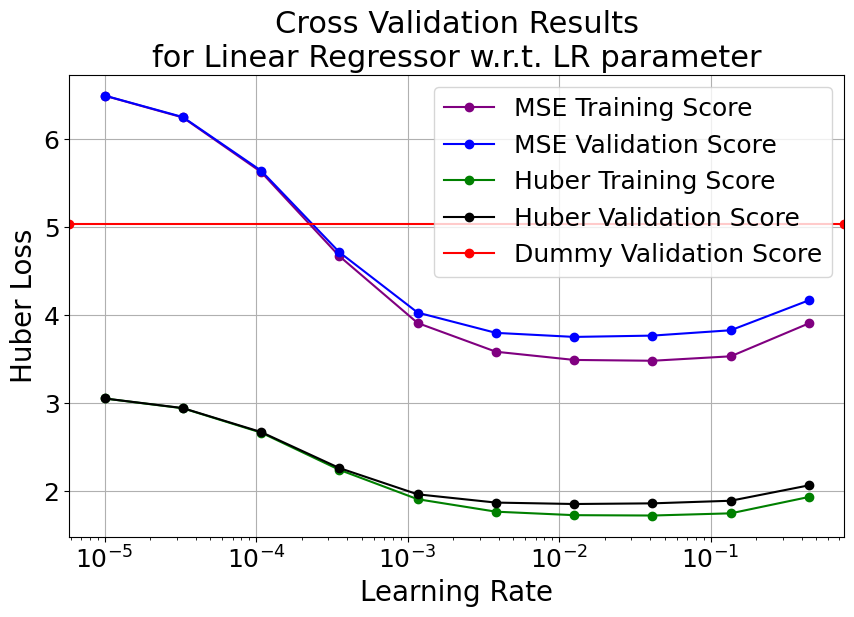

Best LR: 0.012589254117941687
Huber Train Score: 1.7270087375813137
Huber Validation Score: 1.8538368244920367
MSE Train Score: 3.490612637562297
MSE Validation Score: 3.7521627531422865


'\nBest LR: 0.012915496650148827\nHuber Train Score: 1.7266601467013794\nHuber Validation Score: 1.8537733751313958\nMSE Train Score: 3.4898105197615927\nMSE Validation Score: 3.751947180790835\n'

In [14]:

def huber_loss(estimator, x, y):
    return LinearRegressor.loss(estimator.w, estimator.b, x, y, delta)

lr_values = list(np.logspace(-5, -0.35, 10))
# # print(f"delta: {delta}")
huber_train = []
huber_validation = []
mse_train = []
mse_validation = []

for lr in lr_values:
    linear = LinearRegressor(lr=lr, huber_delta=delta)
    # cv_result = cross_validate(linear, prepared_X, prepared_y, cv=5, return_train_score=True, scoring="neg_mean_squared_error", n_jobs=5)

    cv_result = cross_validate(linear, prepared_X, prepared_y, cv=5, return_train_score=True, scoring={"neg_mean_squared_error": "neg_mean_squared_error", "huber_loss": huber_loss}, n_jobs=5)

    mse_train.append(np.abs(np.mean(cv_result["train_neg_mean_squared_error"])))
    mse_validation.append(np.abs(np.mean(cv_result["test_neg_mean_squared_error"])))
    huber_train.append(np.abs(np.mean(cv_result["train_huber_loss"])))
    huber_validation.append(np.abs(np.mean(cv_result["test_huber_loss"])))
    
plt.figure(figsize=(10, 6))
plt.semilogx(lr_values, mse_train, label="MSE Training Score", marker="o", color="purple") 
plt.semilogx(lr_values, mse_validation, label="MSE Validation Score", marker="o", color="blue")
plt.semilogx(lr_values, huber_train, label="Huber Training Score", marker = "o", color="green")
plt.semilogx(lr_values, huber_validation, label="Huber Validation Score", marker="o", color="black")

plt.axhline(y=dummy_validation_score, label="Dummy Validation Score", marker="o", color="red")
plt.xlabel("Learning Rate")
plt.ylabel("Huber Loss")
plt.title("""Cross Validation Results
for Linear Regressor w.r.t. LR parameter""")
plt.legend()
plt.grid(True)
plt.show()

best_index = np.argmin(mse_validation)
best_lr = lr_values[best_index]
print(f"Best LR: {best_lr}")
print(f"Huber Train Score: {huber_train[best_index]}")
print(f"Huber Validation Score: {huber_validation[best_index]}")
print(f"MSE Train Score: {mse_train[best_index]}")
print(f"MSE Validation Score: {mse_validation[best_index]}")

# ## [TODO!] IS THIS RIGHT?
# linear = LinearRegressor(lr=best_lr, huber_delta=delta)
# linear_mse_cv_result = cross_validate(linear, prepared_X, prepared_y, cv=5, return_train_score=True, scoring={"neg_mean_squared_error": "neg_mean_squared_error", "huber_loss": huber_loss}, n_jobs=5)
# # cross_val_res = cross_validate(dummy_regressor, X_train, y_train, cv=k_folds, scoring={"neg_mean_squared_error": scoring, "huber loss": huber_loss})

# neg_mse_test = np.abs(linear_mse_cv_result["test_neg_mean_squared_error"].mean())
# huber_train = np.abs(linear_mse_cv_result["train_huber_loss"].mean())
# print(f"mse test: {neg_mse_test:.5f}, huber train: {huber_train:.5f}")
# TASK !!
linear_regressor = LinearRegressor(lr=best_lr, huber_delta=delta)
linear_regressor.fit(prepared_X, prepared_y)
"""
Best LR: 0.012915496650148827
Huber Train Score: 1.7266601467013794
Huber Validation Score: 1.8537733751313958
MSE Train Score: 3.4898105197615927
MSE Validation Score: 3.751947180790835
"""


In [ ]:
# ## THIS IS A TEST FOR Q9 - PLEASE IGNORE

# # Q3 - psuedo is dead.

# ####### GET UNNORMALIZED DATA
# #############################
# from prepare import transform_features
# lr_values = np.logspace(-5, -1, 10)
# raw_X = transform_features(train_set, False)
# # raw_X = train_set.drop(["contamination_level", "pcr_date", "symptoms"], axis=1)
# raw_y = train_set["contamination_level"]
# # print(raw_X)
# # print(raw_y)
# # print(f"delta: {delta}")

# from sklearn.dummy import DummyRegressor
# # GET DELTA FOR UNNORMALIZED DATA
# #################################

# delta = 100
# # model = LinearRegressor(lr=0.01, huber_delta=100)
# model = DummyRegressor()
# model.fit(raw_X, raw_y)
# residuals = raw_y - model.predict(raw_X)
# residuals = np.abs(residuals)

# quantile_thresholds = [0.5, 0.7, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]
# deltas = list(np.quantile(residuals, quantile_thresholds))
# print(f"deltas: {deltas}")
# from sklearn.model_selection import cross_validate

# test_cv_scores = []
# train_cv_scores = []
# best_score = 0
# best_delta = 0
# # print(f"testing delta: {deltas}")
# for delta in deltas:
#     model = LinearRegressor(lr=0.01, huber_delta=delta)

#     scores = cross_validate(model, raw_X, raw_y, cv=8, return_train_score=True, n_jobs=8)
#     test_cv_scores.append(np.mean(scores["test_score"]))
#     train_cv_scores.append(np.mean(scores["train_score"]))

# best_delta = deltas[np.argmax(test_cv_scores)]
# print(f"train_cv_scores: {train_cv_scores}")
# print(f"test_cv_scores: {test_cv_scores}")
# print(f"Best delta: {best_delta}, corresponds to quantile: {quantile_thresholds[np.argmax(test_cv_scores)]}")


# ####### TRAIN MODEL
# from sklearn.linear_model import LinearRegression


# train_scores = []
# test_scores = []
# for lr in lr_values:
#     linear = LinearRegressor(lr=lr, huber_delta=delta)
#     cv_result = cross_validate(linear, raw_X, raw_y, cv=5, return_train_score=True, scoring="neg_mean_squared_error", n_jobs=5)
#     test_scores.append(np.abs(np.mean(cv_result["test_score"])))
#     train_scores.append(np.abs(np.mean(cv_result["train_score"])))

# plt.figure(figsize=(10, 6))
# plt.semilogx(lr_values, train_scores, label="Huber Training Score")
# plt.semilogx(lr_values, test_scores, label="Huber Validation Score")
# plt.axhline(y=dummy_validation_score, label="Dummy Validation Score", color="red")
# plt.xlabel("Learning Rate")
# plt.ylabel("LOSS")
# plt.title("Cross Validation Results")
# plt.legend()
# plt.grid(True)
# plt.show()

# best_index = np.argmin(test_scores)
# best_lr = lr_values[best_index]
# print(best_lr)
# print(train_scores[best_index])
# print(test_scores[best_index])

# Section 3

## Q10

37.926901907322495
Huber Train Score: 1.7294552878291192
Huber Validation Score: 1.837416765868798
MSE Train Score: 3.497252400629077
MSE Validation Score: 3.7226036500844515


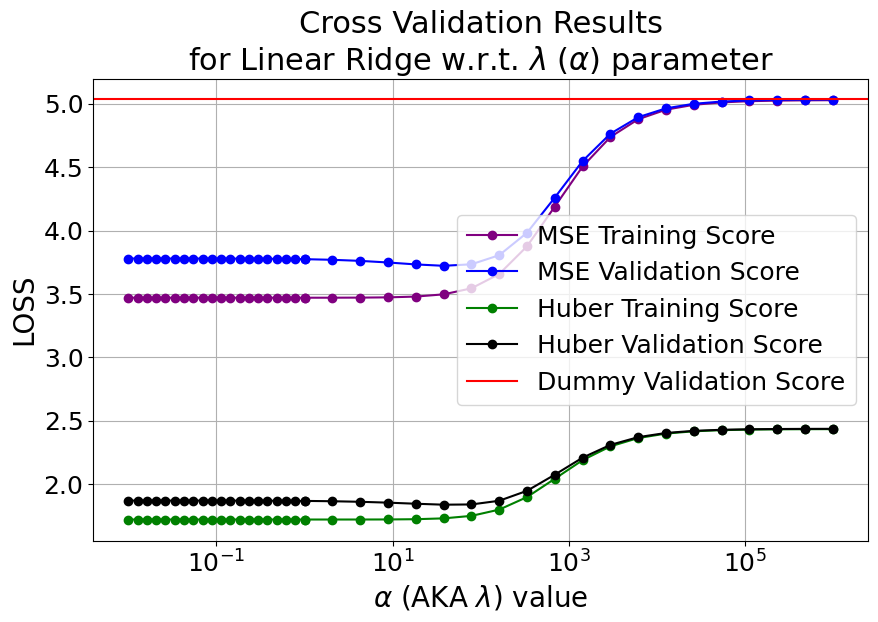

In [15]:
from sklearn.linear_model import HuberRegressor


def huber_loss(estimator: HuberRegressor, X, y, huber_delta=delta):
    intermediate = estimator.predict(X) - y
    is_within_delta = np.abs(intermediate) <= huber_delta
    loss_inside = lambda x: 0.5 * (x**2)
    loss_outside = lambda x: huber_delta * (np.abs(x) - 0.5 * huber_delta)

    return np.sum(np.where(is_within_delta, loss_inside(intermediate), loss_outside(intermediate))) / X.shape[0]

huber_train = []
huber_validation = []
mse_train = []
mse_validation = []

# cross validate the lambda (alpha) parameter
alphas = list(np.logspace(-2, 0, 20)) + list(np.logspace(0, 6, 20))
for alpha in alphas:
    huber = HuberRegressor(alpha=alpha, epsilon=delta)
    cv_result = cross_validate(huber, prepared_X, prepared_y, cv=5, return_train_score=True, scoring={"neg_mean_squared_error": "neg_mean_squared_error", "huber_loss": huber_loss}, n_jobs=5)
    mse_train.append(np.abs(np.mean(cv_result["train_neg_mean_squared_error"])))
    mse_validation.append(np.abs(np.mean(cv_result["test_neg_mean_squared_error"])))
    huber_train.append(np.abs(np.mean(cv_result["train_huber_loss"])))
    huber_validation.append(np.abs(np.mean(cv_result["test_huber_loss"])))

plt.figure(figsize=(10, 6))
plt.semilogx(alphas, mse_train, label="MSE Training Score", marker="o", color="purple") 
plt.semilogx(alphas, mse_validation, label="MSE Validation Score", marker="o", color="blue")
plt.semilogx(alphas, huber_train, label="Huber Training Score", marker = "o", color="green")
plt.semilogx(alphas, huber_validation, label="Huber Validation Score", marker="o", color="black")
plt.axhline(y=dummy_validation_score, label="Dummy Validation Score", color="red")
plt.xlabel(r"$\alpha$ (AKA $\lambda$) value")
plt.ylabel("LOSS")
plt.title(r"""Cross Validation Results
for Linear Ridge w.r.t. $\lambda$ ($\alpha$) parameter""")
plt.legend()
plt.grid(True)
# plt.show()

best_index = np.argmin(mse_validation)
best_alpha = alphas[best_index]
print(best_alpha)
print(f"Huber Train Score: {huber_train[best_index]}")
print(f"Huber Validation Score: {huber_validation[best_index]}")
print(f"MSE Train Score: {mse_train[best_index]}")
print(f"MSE Validation Score: {mse_validation[best_index]}")

## [TODO!] IS THIS RIGHT?
# huber = HuberRegressor(alpha=best_alpha, epsilon=delta)
# huber_mse_cv_result = cross_validate(huber, prepared_X, prepared_y, cv=5, return_train_score=True, scoring="neg_mean_squared_error", n_jobs=5)
# huber_mse_score = np.abs(np.mean(linear_mse_cv_result["test_score"]))
# print(f"Huber MSE Validation Score: {huber_mse_score}")

## Q12

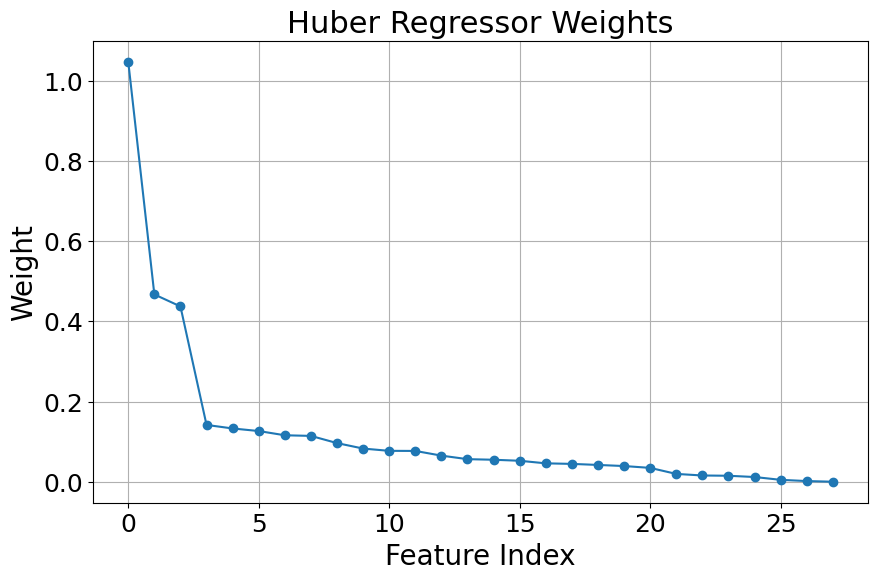

In [ ]:
hoob_regressor = HuberRegressor(alpha=best_alpha, epsilon=delta)
hoob_regressor.fit(prepared_X, prepared_y)

# create a graph of the weights of the model
def plot_weights(weights, title):
    sorted_indices = np.argsort(np.abs(weights))
    sorted_weights = np.abs(weights[sorted_indices])[::-1]

    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(sorted_weights.shape[0]), sorted_weights, marker="o")
    plt.title(title)
    plt.xlabel("Feature Index")
    plt.ylabel("Weight")
    plt.grid(True)
    plt.show()


# plot the weights for the trained hoobRegressor
plot_weights(hoob_regressor.coef_, "Huber Regressor Weights")

# Section 4

## Q14

In [ ]:
def plot3d(df, colX: str, colY: str, colZ: str, title: str, predictions=None):
    fig = plt.figure(figsize=(20, 7))
    axes = [fig.add_subplot(1, 3, i + 1, projection="3d") for i in range(3)]

    palette = sns.color_palette("hls", 2)

    for i, ax in enumerate(axes):
        if predictions is not None:
            ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
            ax.scatter3D(
                df[colX],
                df[colY],
                df[colZ],
                color=palette[0],
                s=1,
                alpha=0.35,
                depthshade=False,
            )
        else:
            ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

        ax.set_xlabel("\n" + colX)
        ax.set_ylabel("\n" + colY)
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])

        ax.view_init(elev=5.0, azim=45 * i)

    axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

    plt.suptitle(title, fontsize=32)
    # plt.tight_layout()

    # import matplotlib as mpl

    # from mpl_toolkits.mplot3d import Axes3D

    # axis3d('x--',labels=T,tick=T)
    # axis3d('y+-',labels=T,tick=T)
    # axis3d('z++',labels=T,tick=T)
    plt.show()




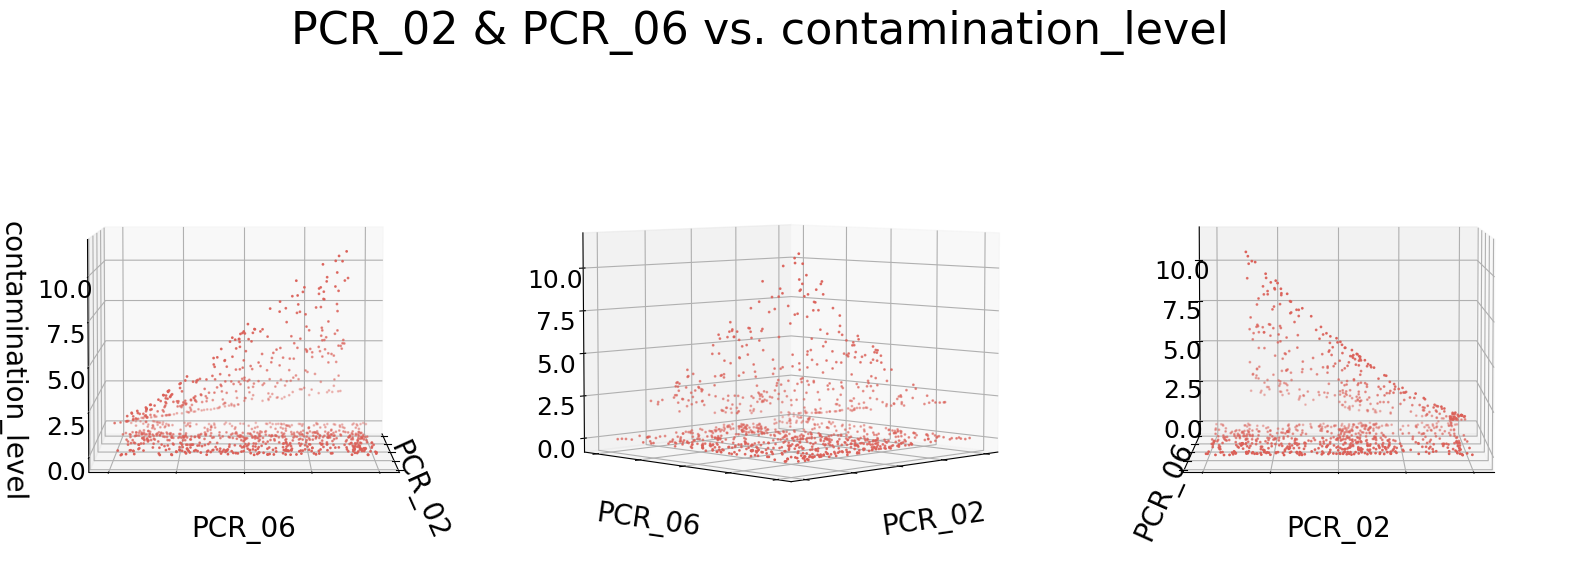

In [ ]:
pcr_2_6_X = prepared_train_set[["PCR_02", "PCR_06", "contamination_level"]] # type: pd.DataFrame
# pcr_2_6_Y = prepared_train_set["contamination_level"].copy() # type: pd.DataFrame

plot3d(pcr_2_6_X, "PCR_02", "PCR_06", "contamination_level", "PCR_02 & PCR_06 vs. contamination_level")




# Q15

In [ ]:
huber_regressor = HuberRegressor(alpha=best_alpha, epsilon=delta, fit_intercept=True)
huber_regressor.fit(pcr_2_6_X.drop("contamination_level", axis=1), pcr_2_6_X["contamination_level"])


HuberRegressor(alpha=37.926901907322495, epsilon=5.760917860337551)

# Q16

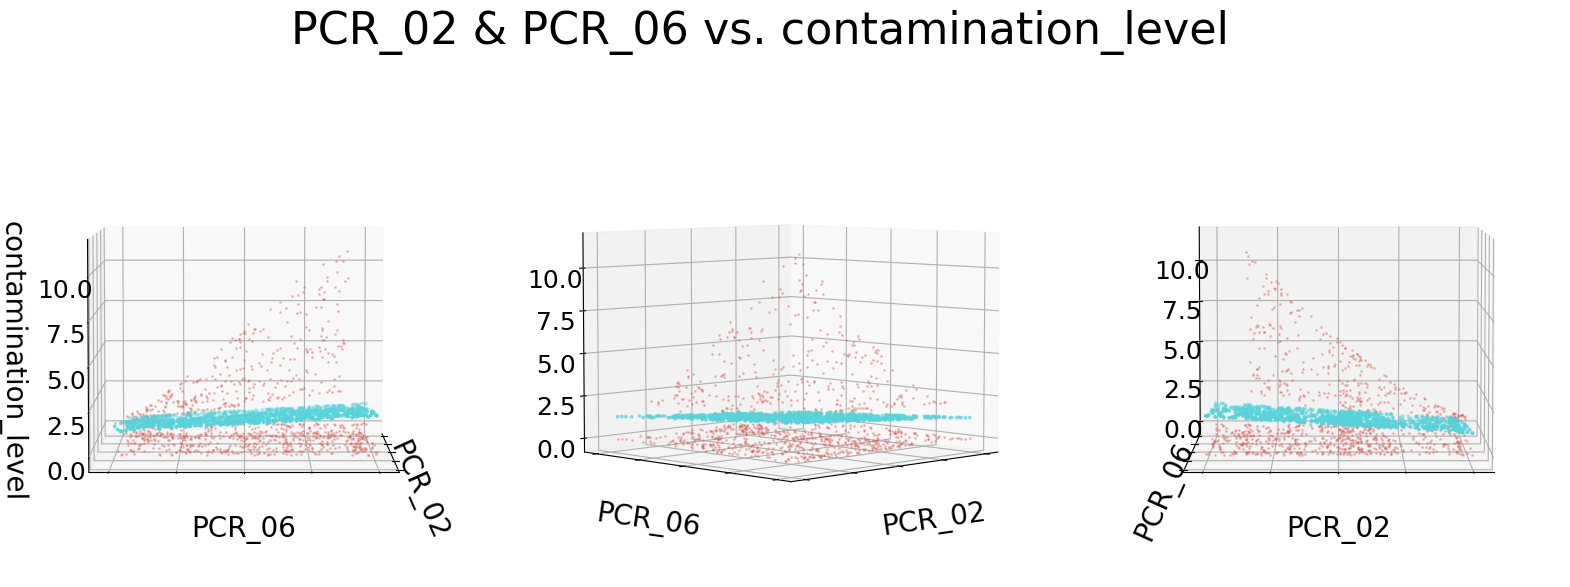

score: 0.04024248196407376


In [ ]:
#plot3d(huber_regressor, "PCR_02", "PCR_06", "contamination_level", "PCR_02 & PCR_06 vs. contamination_level")


# pcr_2_6_X = prepared_train_set[["PCR_02", "PCR_06", "contamination_level"]] # type: pd.DataFrame
# # pcr_2_6_Y = prepared_train_set["contamination_level"].copy() # type: pd.DataFrame
pcr_2_6 = pcr_2_6_X.drop('contamination_level',axis="columns")
plot3d(pcr_2_6_X, "PCR_02", "PCR_06", "contamination_level", "PCR_02 & PCR_06 vs. contamination_level",huber_regressor.predict(pcr_2_6))
print(f"score: {huber_regressor.score(pcr_2_6, pcr_2_6_X['contamination_level'])}")

# Q17

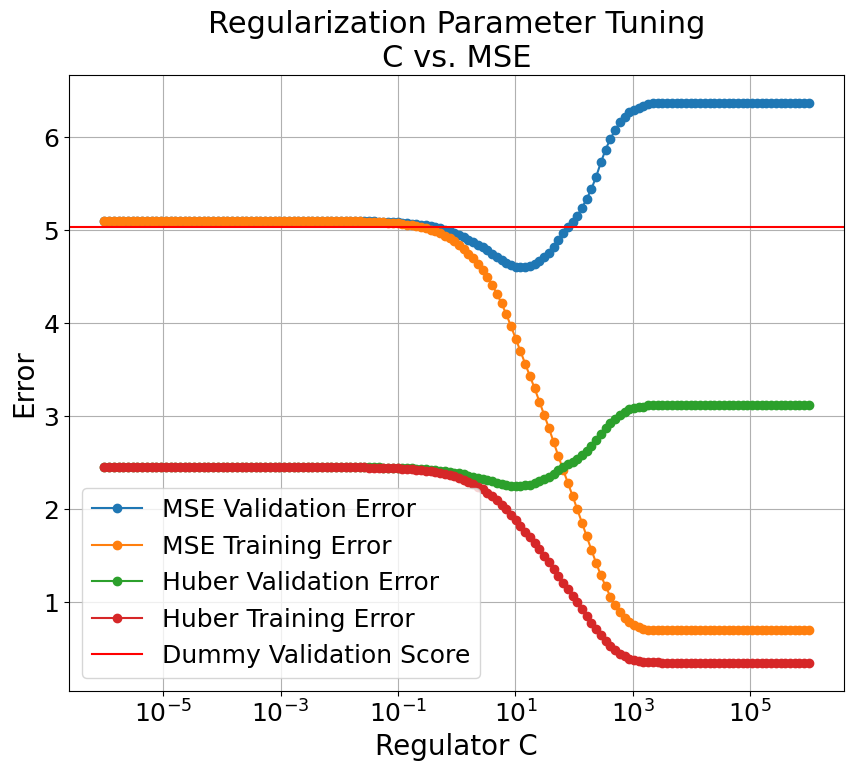

({'regressor__C': 14.715846019280558}, -4.5988997949919135)
-4.5988997949919135
14.715846019280558
Best C: 14.715846019280558
MSE Validation Score for Best C: 4.5988997949919135
Huber training score for best c: 3.5624044553812917


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics.pairwise import laplacian_kernel
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV


c_range = np.logspace(-6, 6, 150)
param_dict = {"regressor__C": c_range}
poly_reg = Pipeline([('normalization', MinMaxScaler((-1, 1))),  ('regressor', SVR(kernel=laplacian_kernel, tol=1e-5, C=0, epsilon=1))])
grid = GridSearchCV(poly_reg, param_dict, cv=5, n_jobs=5, scoring={"mse": "neg_mean_squared_error", "huber_loss": huber_loss}, return_train_score=True, refit=False)
grid.fit(prepared_train_set[["PCR_02", "PCR_06"]], prepared_y)
# grid.predict(prepared_test_set[["PCR_02", "PCR_06"]])
plt.figure(figsize=(10, 8))  # Increase the figure size

plt.plot(c_range, -grid.cv_results_["mean_test_mse"], label="MSE Validation Error", marker="o")
plt.plot(c_range, -grid.cv_results_['mean_train_mse'], label="MSE Training Error", marker="o")
plt.plot(c_range, grid.cv_results_['mean_test_huber_loss'], label="Huber Validation Error", marker="o")
plt.plot(c_range, grid.cv_results_['mean_train_huber_loss'], label="Huber Training Error", marker="o")

plt.axhline(y=dummy_validation_score, label="Dummy Validation Score", color="red")

plt.xlabel('Regulator C')
plt.ylabel('Error')

plt.title("Regularization Parameter Tuning\nC vs. MSE")
plt.xscale('log')
plt.legend(loc='lower left')  # Move the legend to the lower right
# plt.legend()
plt.grid(True)
plt.show()

# best_c = c_range[np.argmax(grid.cv_results_["mean_test_score"])]
# print(grid.best_params_)
# print(grid.best_score_)

lst = list(zip(grid.cv_results_['params'], grid.cv_results_['mean_test_mse']))

print(max(lst, key=lambda x: x[1]))

print(grid.cv_results_["mean_test_mse"].max())
best_c = c_range[np.argmax(grid.cv_results_["mean_test_mse"])]
print(best_c)

best_c_index = np.argmax(grid.cv_results_["mean_test_mse"])
print("Best C:", c_range[best_c_index])
print(f"MSE Validation Score for Best C: {-grid.cv_results_['mean_test_mse'][best_c_index]}")
print(f"Huber training score for best c: {-grid.cv_results_['mean_train_mse'][best_c_index]}")



In [ ]:
poly_reg.set_params(regressor__C=best_c)
poly_reg.fit(prepared_train_set[['PCR_02', 'PCR_06']], prepared_y)
# svr_regressor = SVR(kernel=laplacian_kernel, tol=1e-5, C=best_c, epsilon=1)
# svr_regressor.fit(prepared_train_set[['PCR_02','PCR_06']], prepared_y)
print("best c: ", best_c)

best c:  12.648552168552959


# Q18

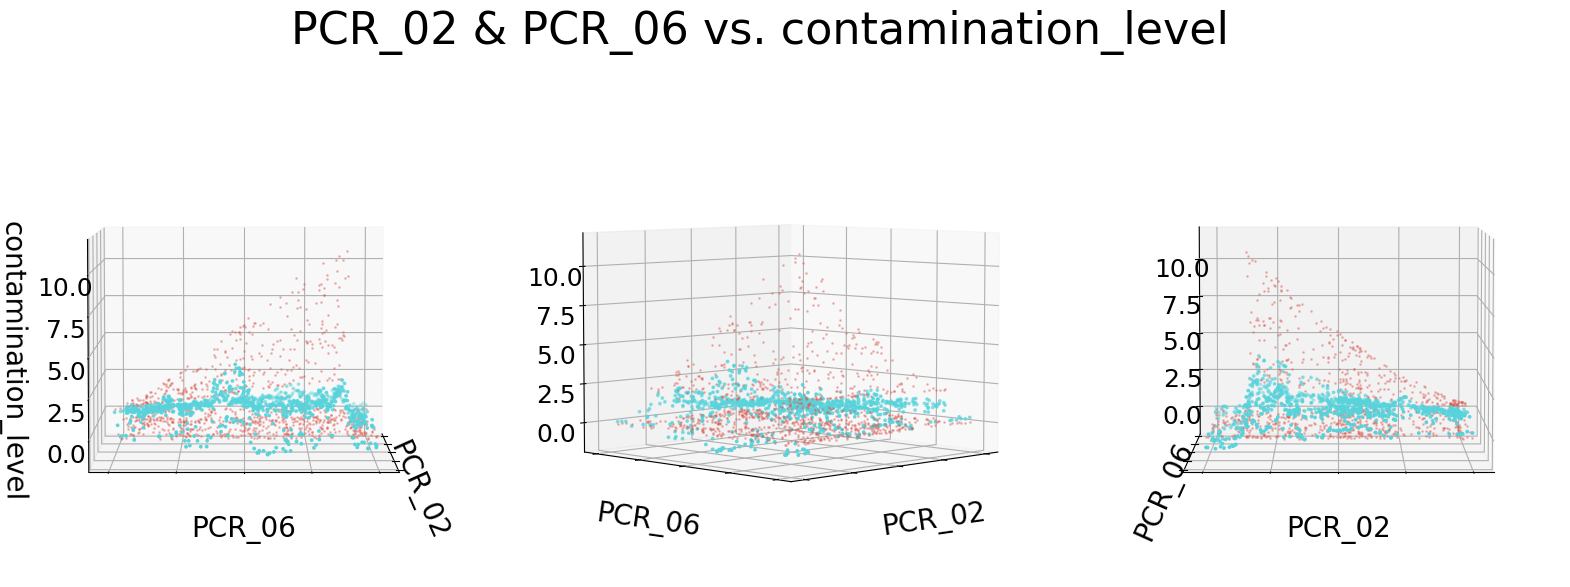

score:  0.23765242989225233


In [ ]:

# pcr_2_6 = pcr_2_6_X.drop('contamination_level',axis="columns")
predictions = poly_reg.predict(prepared_train_set[['PCR_02', 'PCR_06']])
score = poly_reg.score(prepared_train_set[['PCR_02', 'PCR_06']], prepared_y)
plot3d(prepared_train_set[['PCR_02', 'PCR_06', 'contamination_level']], "PCR_02", "PCR_06", "contamination_level", "PCR_02 & PCR_06 vs. contamination_level", predictions)
print("score: ", score)

# IML Major HW 3 - Linear Regression
| Name | ID |
|------|----|
| Daniel Gershkovich   | 209088723  |
| Assaf Alon   | 207376807  |
| Saar Gablinger | 209493311  |

In [ ]:
test_X = prepared_test_set.drop('contamination_level', axis=1)
test_y = prepared_test_set['contamination_level']

poly_reg.fit(prepared_X, prepared_y)


linear_predictions = linear_regressor.predict(test_X)
ridge_predictions = hoob_regressor.predict(test_X)
svr_laplace_predictions = poly_reg.predict(test_X)
dummy_redictions = dummy.predict(test_X)

# get mse, hoob scores manually
linear_mse = np.mean((test_y - linear_predictions) ** 2)
ridge_mse = np.mean((test_y - ridge_predictions) ** 2)
poly_mse = np.mean((test_y - svr_laplace_predictions) ** 2)
dummy_mse = np.mean((test_y - dummy_redictions) ** 2)

print(f"Dummy MSE: {dummy_mse}")
print(f"Linear MSE: {linear_mse}")
print(f"Ridge MSE: {ridge_mse}")
print(f"Poly MSE: {poly_mse}")


Dummy MSE: 6.135148308766614
Linear MSE: 4.854927755182945
Ridge MSE: 4.809995652370091
Poly MSE: 2.779385590202136
